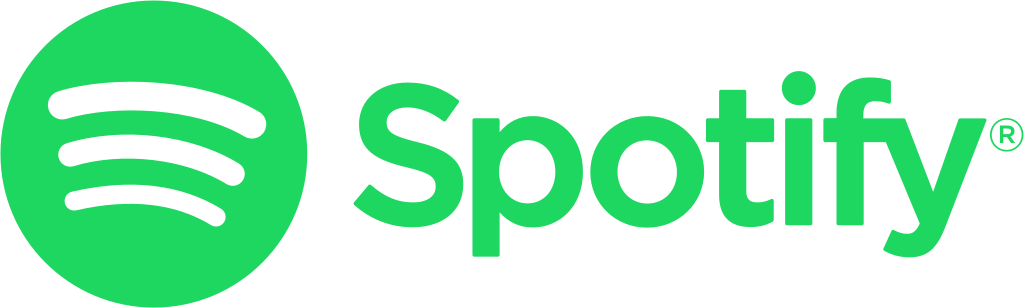

### **DEFINICIÓN PROBLEMA**

El objetivo que quiero es crear una playlist afín a mis gustors, con las canciones de más exito del momento.


El objetivo buscado es crear una playlist según el estado de ánimo de las canciones

Para ello, seguiré los siguientes pasos:
1. Obtención de los datos mediante web scrapping de Spotify Web.
2. Crear etiquetas para cada canción.


2. Obtener las listas/paises donde se alcanza mayor energia
3. Artistas más escuchados por pais ... recomendaciones para cada pais


Bibliografia:
-
- https://spotipy.readthedocs.io/en/2.22.1/
- https://sites.tufts.edu/eeseniordesignhandbook/2015/music-mood-classification/

#### DATA

In [2]:
# Libraries used

from bs4 import BeautifulSoup # for web scraping


import matplotlib.pyplot as plt # for visualization
import numpy as np # for numerical computing

import pandas as pd # for data manipulation and analysis
import pycountry # for accesing ISO databases of countries and languages


import os

import requests # is used for making HTTP requests.
import seaborn as sns # for visualization

import spotipy #is a lightweight Python library for the Spotify Web API.
from spotipy import SpotifyException
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth # used for Spotify API authentication

import time

### **GETTING DATA FROM SPOTIFY:**

#### 1. Requesting access to the Spotify API:

In [3]:
# Spotify client items:
client_id = "ef77e31c5d4049818901058b81bd56a3"
client_secret = "c773be9c070044e2ad067db5f86b62cb"
uri = "http://localhost:8080"

In [4]:
# Endpoint
token_url = "https://accounts.spotify.com/api/token"

# Parameters
data = {
    "grant_type": "client_credentials",
    "client_id": client_id,
    "client_secret": client_secret
}

# Make the POST request to obtain the access token
response = requests.post(token_url, data=data)

In [5]:
# Check if the request was successful
if response.status_code == 200:
    # Extract the access token from the response body
    access_token = response.json()["access_token"]
    print("Access token obtained:", access_token)
else:
    print("Failed to obtain access token. Status code:", response.status_code)

Access token obtained: BQBOwOPGGpZ8iuW5iwk66MlQdm7jUxp8JTve4DPRBiki_o1wr8W6MKpcs7iRgoMU-HqlsKhohaa3lnZB7VP6lNV34W5kwRLJ8tnOnjDS6buWkWCYSnA


From this moment on, I'm using the ``Spotipy`` library, which provides a Python interface for the Spotify Web API, facilitating interaction with the data and features provided by Spotify. The library allows access to a wide range of functionalities and comes with comprehensive documentation and usage examples that make learning and effective use easier.

In [6]:
# Initialize the Spotify authentication client
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

# Create a Spotify object, for  requesting
sp = spotipy.Spotify(auth_manager=auth_manager)

#### 2. List of countries:

``PyCountry`` is a useful tool for working with data related to countries in Python applications, providing a convenient way to access standardized information about countries, their codes, and other associated details."

In [13]:
# Obtain the data of countries
countries_data = list(pycountry.countries)

In [14]:
# Expample  for France:
print(f"Name: {countries_data[75].name} \nCode: {countries_data[75].alpha_2}")

Name: France 
Code: FR


In [15]:
# List of countries and list of codes
countries_names = [country.name for country in countries_data]
countries_codes = [country.alpha_2 for country in countries_data]

#### 3. Playlist_ids dataframe:

In [16]:
# Create an empty list to store the data
playlist_list = []
counter=0

# Iterate over each country
for name in countries_names:
    playlist_name = f"Top 50: {name}"

    # Perform the search for the playlist by its name
    results = sp.search(q=playlist_name, type='playlist')

    # Check if any playlists were found
    if results['playlists']['items']:
        # Iterate over each search result
        for item in results['playlists']['items']:
            # Check if the owner is Spotify
            if item['owner']['id'] == 'Spotify' or item['owner']['id'] == 'spotify':
                # Add the playlist data to the list
                playlist_list.append({
                    'country':name,
                    'playlist_id': item['id']
                })
                break  # Break the loop once a Spotify playlist is found
    else:
        # Print a message if no playlists were found for the country
        counter = counter + 1
        print("No playlist found with the name '{}' for country '{}'".format(playlist_name, name))
        print(f"Number of not found countries: {counter}")
        print("*"*20)



No playlist found with the name 'Top 50: Åland Islands' for country 'Åland Islands'
Number of not found countries: 1
********************
No playlist found with the name 'Top 50: Micronesia, Federated States of' for country 'Micronesia, Federated States of'
Number of not found countries: 2
********************
No playlist found with the name 'Top 50: Gibraltar' for country 'Gibraltar'
Number of not found countries: 3
********************
No playlist found with the name 'Top 50: Guam' for country 'Guam'
Number of not found countries: 4
********************
No playlist found with the name 'Top 50: Heard Island and McDonald Islands' for country 'Heard Island and McDonald Islands'
Number of not found countries: 5
********************
No playlist found with the name 'Top 50: British Indian Ocean Territory' for country 'British Indian Ocean Territory'
Number of not found countries: 6
********************
No playlist found with the name 'Top 50: Marshall Islands' for country 'Marshall Islands

It seem that for small countries there are not playlist called "Top 50". 

``15 not found when collected data. ``


Every time I run this code cell, the number of countries not found varies... this may be because the playlist I'm searching for is being updated.

In [17]:
playlist_list[60:65]

[{'country': 'Finland', 'playlist_id': '37i9dQZEVXbMxcczTSoGwZ'},
 {'country': 'Fiji', 'playlist_id': '37i9dQZF1E4zop6UXS5B2i'},
 {'country': 'Falkland Islands (Malvinas)',
  'playlist_id': '37i9dQZF1DZ06evO0UYisi'},
 {'country': 'France', 'playlist_id': '37i9dQZEVXbIPWwFssbupI'},
 {'country': 'Faroe Islands', 'playlist_id': '37i9dQZF1E8ECq6GLf8rfj'}]

In [18]:
# Example for France:
france_pl_id = playlist_list[63]['playlist_id']

# Printing the playlist ID for France
print("Playlist ID for France:", france_pl_id)


Playlist ID for France: 37i9dQZEVXbIPWwFssbupI


Top 50: France --> playlist_id

<img src="./img/france_playlist_id.png" alt="France web Scrapping" width="1000" height="300">

In [19]:
def get_playlist_info(playlist_id):
    try:
        # Use the playlist() function from Spotipy to retrieve playlist information
        playlist_info = sp.playlist(playlist_id)
        return playlist_info
    except spotipy.SpotifyException as e:
        print("Error getting playlist information:", e)
        return None

In [20]:
# Example for France:
france_info = get_playlist_info(france_pl_id)
france_info

{'collaborative': False,
 'description': 'Your daily update of the most played tracks right now - France.',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZEVXbIPWwFssbupI'},
 'followers': {'href': None, 'total': 844016},
 'href': 'https://api.spotify.com/v1/playlists/37i9dQZEVXbIPWwFssbupI?additional_types=track',
 'id': '37i9dQZEVXbIPWwFssbupI',
 'images': [{'height': None,
   'url': 'https://charts-images.scdn.co/assets/locale_en/regional/daily/region_fr_large.jpg',
   'width': None}],
 'name': 'Top 50 - France',
 'owner': {'display_name': 'Spotify',
  'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'},
  'href': 'https://api.spotify.com/v1/users/spotify',
  'id': 'spotify',
  'type': 'user',
  'uri': 'spotify:user:spotify'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'NzY0NTgzNjAwLDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDY1NmU=',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/37i9dQZEVXbIPWwFssbupI/tracks?o

I need any funtion to take out the information --> followers and total songs

In [21]:
def get_playlist_data(playlist_id):
    playlist_info = get_playlist_info(playlist_id)
    if playlist_info:
        followers = playlist_info['followers']['total']
        total_songs = playlist_info['tracks']['total']
        return pd.Series({'followers': followers, 'total_songs': total_songs})
    else:
        return pd.Series({'followers': None, 'total_songs': None})

In [22]:
# Example for France:
france_info_processed = get_playlist_data(france_pl_id)
france_info_processed

followers      844016
total_songs        50
dtype: int64

In [23]:
# Create a DataFrame from the list of playlist data
playlist_data = []

# Iterate over playlist_list and extract required information
for playlist in playlist_list:
    country = playlist['country']
    playlist_id = playlist['playlist_id']
    info = get_playlist_data(playlist_id)

    playlist_data.append({'country': country,
                          'playlist_id': playlist_id,
                          'followers': info['followers'],
                          'total_songs': info['total_songs']})

# Create a DataFrame from the list of playlist data
playlist_df = pd.DataFrame(playlist_data)
playlist_df.sample(10)

,country,playlist_id,followers,total_songs
0,Aruba,37i9dQZEVXbMJJi3wgRbAy,117667,50
165,Suriname,37i9dQZF1EIdrY460qeUUA,0,50
39,Colombia,37i9dQZEVXbOa2lmxNORXQ,827199,50
151,Rwanda,37i9dQZF1DWZgbYyehYtQC,2177,60
44,Cayman Islands,37i9dQZF1E8LLkkCbcA75c,60,50
53,Ecuador,37i9dQZEVXbJlM6nvL1nD1,181926,50
149,French Polynesia,37i9dQZF1EIdjOVgwfpWk6,0,50
108,Latvia,37i9dQZEVXbJWuzDrTxbKS,14819,50
174,Tajikistan,37i9dQZEVXbLeBcWrdps2V,16359,50
7,Antarctica,37i9dQZF1E8LuxxcOL61gQ,0,50


In [30]:
# Save changes:
#playlist_df.to_csv("./data/playlist_df.csv")

#### 5. Artists dataframe:

In [24]:
def create_playlist_df(playlist_dataframe, country):
    playlist_id_series = playlist_dataframe.loc[playlist_dataframe['country'] == country]["playlist_id"]
    
    # Check if playlist_id_series is empty
    if playlist_id_series.empty:
        print("Playlist not found for the country:", country)
        return None
    
    playlist_id = playlist_id_series.iloc[0]  # Extract the playlist ID from the Series
    playlist_info = get_playlist_info(playlist_id)

    if not playlist_info:
        print("Error: Playlist information not found for ID:", playlist_id)
        return None
    
    tracks = playlist_info['tracks']['items']
    playlist_data = []

    for track in tracks:
        artist = track['track']['artists'][0]['name']
        album = track['track']['album']['name']
        song_name = track['track']['name']
        release_date = track['track']['album']['release_date']
        duration_ms = track['track']['duration_ms']
        popularity = track['track']['popularity']
        track_id = track['track']['id']

        playlist_data.append({
            'country': country,
            'artist': artist,
            'album': album,
            'song_name': song_name,
            'release_date': release_date,
            'duration_ms': duration_ms,
            'popularity': popularity,
            'track_id': track_id
        })

    playlist_df = pd.DataFrame(playlist_data)
    return playlist_df

In [25]:
# Example for France:
france_df = create_playlist_df(playlist_df,"France")
france_df.head(10)

,country,artist,album,song_name,release_date,duration_ms,popularity,track_id
0,France,Benson Boone,Beautiful Things,Beautiful Things,2024-01-18,180304,100,6tNQ70jh4OwmPGpYy6R2o9
1,France,Jungeli,Petit génie,Petit génie,2023-08-04,217259,81,1eldTykrnkEBLX41bk5eMw
2,France,Gazo,LA MELO EST GANGX,MAMI WATA,2023-12-01,233240,79,6yqwxY8qifBBhyryjZutxk
3,France,Pierre Garnier,Ceux qu'on était,Ceux qu'on était,2024-02-07,174106,80,5Pzh42xn3oAXHh4U7tVHMr
4,France,Dadju,HÉRITAGE,I love you,2024-02-16,237866,69,6jDe94y1dbLDU53Q1NPxLH
5,France,Teddy Swims,I've Tried Everything But Therapy (Part 1),Lose Control,2023-09-15,210688,93,17phhZDn6oGtzMe56NuWvj
6,France,Franglish,Prime,Position,2024-02-15,141226,74,3Zw66L4FvI9YUUx17OReRD
7,France,Werenoi,Pyramide,Pyramide,2024-02-16,208405,77,0y79GClHejq2TTQLaYFLUT
8,France,iñigo quintero,Si No Estás,Si No Estás,2022-09-23,184061,90,2HafqoJbgXdtjwCOvNEF14
9,France,Beyoncé,TEXAS HOLD 'EM,TEXAS HOLD 'EM,2024-02-10,235636,86,7AYmToZ5y67fBjq4RLFbuq


In [26]:
# All Artist dataframe:

# Create a list to store DataFrames of artists from each country
artist = []

# Iterate over each country in playlist_df["country"]
for country in playlist_df["country"]:
    # Get the DataFrame of artists for the current country
    artist_country_df = create_playlist_df(playlist_df, country)
    # Add the DataFrame to the list
    artist.append(artist_country_df)

# Concatenate the DataFrames of artists into one
artist_df = pd.concat(artist, ignore_index=True)

In [27]:
artist_df.sample(10)

,country,artist,album,song_name,release_date,duration_ms,popularity,track_id
9869,South Africa,Tyla,TYLA,Jump,2024-03-22,147071,56,6XpEm7VJ7TZxZTawH8BCSW
8663,Seychelles,Thom Merlin,Ride You To The Moon,Ride You To The Moon,2021-05-28,154576,41,5WESJl8LIW1tV7pMGZem9e
8098,Sierra Leone,Mt. Eden,MEDS EP,What's Below,2010-12-08,239999,24,5zLABygBfwMj7tbEq9XHbJ
4469,Iceland,Hafdís Huld,Vögguvísur,Bíum bíum bambaló,2012-06-04,175403,46,5pn6OskYybJrrqcdlNpBvk
5180,Libya,Mae Stephens,If We Ever Broke Up,If We Ever Broke Up,2023-02-10,142758,78,6maTPqynTmrkWIralgGaoP
6482,Niger,Seyi Vibez,NAHAMciaga,Different Pattern,2023-12-08,123333,69,7FB5261Iv3MRbSz13HYP5l
543,Austria,soffie,Für immer Frühling,Für immer Frühling,2024-02-02,120000,77,3pn5z4CvMz95uEysWBUYCc
9473,Uruguay,Sayian Jimmy,Controlando el Ki,Bad Boy,2023-11-10,159101,74,6PMapQ7YSxkhAgNOvvoiWs
7554,"Palestine, State of",Le Trio Joubran,The Long March,Carry the Earth,2018-10-12,376586,26,73XTg0Yt03seww60tQcBSL
2217,Cuba,Xavi,La Diabla,La Diabla,2023-11-30,172264,95,0R6NfOiLzLj4O5VbYSJAjf


In [28]:
artist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9996 entries, 0 to 9995
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       9996 non-null   object
 1   artist        9996 non-null   object
 2   album         9996 non-null   object
 3   song_name     9996 non-null   object
 4   release_date  9996 non-null   object
 5   duration_ms   9996 non-null   int64 
 6   popularity    9996 non-null   int64 
 7   track_id      9996 non-null   object
dtypes: int64(2), object(6)
memory usage: 624.9+ KB


In [29]:
# Save changes:
#artist_df.to_csv("./data/artist_df.csv")

In [9]:
# Import dataframe:
artist_df=pd.read_csv("./data/artist_df.csv")

#### Music dataframe:

In [7]:
# Create a function to retrieve the audio features of a song
def get_audio_features(track_id):
    # Retrieve the audio features of the song using the track_id
    audio_features = sp.audio_features(track_id)
    return audio_features[0] if audio_features else None

To avoid the error of exceeding the request limit to the Spotify API, i split the list of track IDs into smaller batches and make requests for each batch.

In [8]:
def retry_with_backoff(func, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            return func()
        except SpotifyException as e:
            if e.http_status == 429:  # Rate limit exceeded
                print(f"Rate limit exceeded. Waiting before retrying... (Retry {retries + 1}/{max_retries})")
                time.sleep(2 ** retries)  # Exponential backoff
                retries += 1
            else:
                raise  # Re-raise exception if it's not rate limiting related
    raise RuntimeError("Max retries reached without a successful response.")

# Function to retrieve audio features with retry mechanism and backoff strategy
def get_audio_features_with_retry_backoff(track_id):
    return retry_with_backoff(lambda: sp.audio_features(track_id))

In [10]:
# Batch size definition
batch_size = 100

# Definition of track_id batches
track_batches_1 = artist_df["track_id"][0:2000]
track_batches_2 = artist_df["track_id"][2000:4000]
track_batches_3 = artist_df["track_id"][4000:6000]
track_batches_4 = artist_df["track_id"][6000:8000]
track_batches_5 = artist_df["track_id"][8000:]

In [11]:
# Directory where the CSV files will be saved
output_directory = "data"

# Create the directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# List to store all the audio feature DataFrames
audio_features_dfs = []

In [12]:
# List to store all the audio feature DataFrames
audio_features_dfs_1 = []

# Iterate over the track_id batches 1/5
for track_batch in track_batches_1:
    # List to store the audio data for this batch
    audio_data_batch = []

    # Request audio features for the current batch
    for track_id in track_batch:
        audio_features = get_audio_features_with_retry_backoff(track_id)
        audio_data_batch.append(audio_features)
    
    # Convert the list of dictionaries into a Pandas DataFrame
    audio_df_batch = pd.DataFrame(audio_data_batch)

    # Save the DataFrame to a CSV file
    batch_filename = os.path.join(output_directory, f"batch_{len(audio_features_dfs) + 1}.csv")
    audio_df_batch.to_csv(batch_filename, index=False)
    
    # Add the DataFrame to the list of audio feature DataFrames
    audio_features_dfs_1.append(audio_df_batch)

    # Show progress message
    print(f"Processed batch {len(audio_features_dfs_1)} of {len(track_batches_1)}")

# Concatenate all the DataFrames into a single one
audio_features_df_1 = pd.concat(audio_features_dfs_1, ignore_index=True)

# Save the concatenated DataFrame to a CSV file
audio_features_df_1.to_csv(os.path.join(output_directory, "audio_features_combined.csv"), index=False)

Max Retries reached


Rate limit exceeded. Waiting before retrying... (Retry 1/3)


Max Retries reached


Rate limit exceeded. Waiting before retrying... (Retry 2/3)


Max Retries reached


Rate limit exceeded. Waiting before retrying... (Retry 3/3)


RuntimeError: Max retries reached without a successful response.

In [ ]:
# List to store all the audio feature DataFrames
audio_features_dfs_2 = []

# Iterate over the track_id batches 2/5
for track_batch in track_batches_2:
    # List to store the audio data for this batch
    audio_data_batch = []

    # Request audio features for the current batch
    for track_id in track_batch:
        audio_features = get_audio_features_with_retry_backoff(track_id)
        audio_data_batch.append(audio_features)
    
    # Convert the list of dictionaries into a Pandas DataFrame
    audio_df_batch = pd.DataFrame(audio_data_batch)

    # Save the DataFrame to a CSV file
    batch_filename = os.path.join(output_directory, f"batch_{len(audio_features_dfs) + 1}.csv")
    audio_df_batch.to_csv(batch_filename, index=False)
    
    # Add the DataFrame to the list of audio feature DataFrames
    audio_features_dfs_2.append(audio_df_batch)

    # Show progress message
    print(f"Processed batch {len(audio_features_dfs_2)} of {len(track_batches_2)}")

# Concatenate all the DataFrames into a single one
audio_features_df_2 = pd.concat(audio_features_dfs_2, ignore_index=True)

# Save the concatenated DataFrame to a CSV file
audio_features_df_2.to_csv(os.path.join(output_directory, "audio_features_combined.csv"), index=False)

In [ ]:
# List to store all the audio feature DataFrames
audio_features_dfs_3 = []

# Iterate over the track_id batches 3/5
for track_batch in track_batches_3:
    # List to store the audio data for this batch
    audio_data_batch = []

    # Request audio features for the current batch
    for track_id in track_batch:
        audio_features = get_audio_features_with_retry_backoff(track_id)
        audio_data_batch.append(audio_features)
    
    # Convert the list of dictionaries into a Pandas DataFrame
    audio_df_batch = pd.DataFrame(audio_data_batch)

    # Save the DataFrame to a CSV file
    batch_filename = os.path.join(output_directory, f"batch_{len(audio_features_dfs) + 1}.csv")
    audio_df_batch.to_csv(batch_filename, index=False)
    
    # Add the DataFrame to the list of audio feature DataFrames
    audio_features_dfs_3.append(audio_df_batch)

    # Show progress message
    print(f"Processed batch {len(audio_features_dfs_3)} of {len(track_batches_3)}")

# Concatenate all the DataFrames into a single one
audio_features_df_3 = pd.concat(audio_features_dfs_3, ignore_index=True)

# Save the concatenated DataFrame to a CSV file
audio_features_df_3.to_csv(os.path.join(output_directory, "audio_features_combined.csv"), index=False)

In [ ]:
# List to store all the audio feature DataFrames
audio_features_dfs_4 = []

# Iterate over the track_id batches 4/5
for track_batch in track_batches_4:
    # List to store the audio data for this batch
    audio_data_batch = []

    # Request audio features for the current batch
    for track_id in track_batch:
        audio_features = get_audio_features_with_retry_backoff(track_id)
        audio_data_batch.append(audio_features)
    
    # Convert the list of dictionaries into a Pandas DataFrame
    audio_df_batch = pd.DataFrame(audio_data_batch)

    # Save the DataFrame to a CSV file
    batch_filename = os.path.join(output_directory, f"batch_{len(audio_features_dfs) + 1}.csv")
    audio_df_batch.to_csv(batch_filename, index=False)
    
    # Add the DataFrame to the list of audio feature DataFrames
    audio_features_dfs_4.append(audio_df_batch)

    # Show progress message
    print(f"Processed batch {len(audio_features_dfs_4)} of {len(track_batches_4)}")

# Concatenate all the DataFrames into a single one
audio_features_df_4 = pd.concat(audio_features_dfs_4, ignore_index=True)

# Save the concatenated DataFrame to a CSV file
audio_features_df_4.to_csv(os.path.join(output_directory, "audio_features_combined.csv"), index=False)

In [ ]:
# List to store all the audio feature DataFrames
audio_features_dfs_5 = []

# Iterate over the track_id batches 5/5
for track_batch in track_batches_5:
    # List to store the audio data for this batch
    audio_data_batch = []

    # Request audio features for the current batch
    for track_id in track_batch:
        audio_features = get_audio_features_with_retry_backoff(track_id)
        audio_data_batch.append(audio_features)
    
    # Convert the list of dictionaries into a Pandas DataFrame
    audio_df_batch = pd.DataFrame(audio_data_batch)

    # Save the DataFrame to a CSV file
    batch_filename = os.path.join(output_directory, f"batch_{len(audio_features_dfs) + 1}.csv")
    audio_df_batch.to_csv(batch_filename, index=False)
    
    # Add the DataFrame to the list of audio feature DataFrames
    audio_features_dfs_5.append(audio_df_batch)

    # Show progress message
    print(f"Processed batch {len(audio_features_dfs_5)} of {len(track_batches_5)}")

# Concatenate all the DataFrames into a single one
audio_features_df_5 = pd.concat(audio_features_dfs_5, ignore_index=True)

# Save the concatenated DataFrame to a CSV file
audio_features_df_5.to_csv(os.path.join(output_directory, "audio_features_combined.csv"), index=False)

In [ ]:
# Iterate over the track_id batches 2/5
for track_batch in track_batches_2:
    # List to store the audio data for this batch
    audio_data_batch = []

    # Request audio features for the current batch
    for track_id in track_batch:
        audio_features = get_audio_features_with_retry_backoff(track_id)
        audio_data_batch.append(audio_features)
    
    # Convert the list of dictionaries into a Pandas DataFrame
    audio_df_batch = pd.DataFrame(audio_data_batch)

    # Save the DataFrame to a CSV file
    batch_filename = os.path.join(output_directory, f"batch_{len(audio_features_dfs) + 1}.csv")
    audio_df_batch.to_csv(batch_filename, index=False)
    
    # Add the DataFrame to the list of audio feature DataFrames
    audio_features_dfs.append(audio_df_batch)

    # Show progress message
    print(f"Processed batch {len(audio_features_dfs)} of {len(track_batches_2)}")

# Concatenate all the DataFrames into a single one
audio_features_df_2 = pd.concat(audio_features_dfs, ignore_index=True)

# Save the concatenated DataFrame to a CSV file
audio_features_df_2.to_csv(os.path.join(output_directory, "audio_features_combined.csv"), index=False)

In [ ]:
# Iterate over the track_id batches 3/5
for track_batch in track_batches_3:
    # List to store the audio data for this batch
    audio_data_batch = []

    # Request audio features for the current batch
    for track_id in track_batch:
        audio_features = get_audio_features_with_retry_backoff(track_id)
        audio_data_batch.append(audio_features)
    
    # Convert the list of dictionaries into a Pandas DataFrame
    audio_df_batch = pd.DataFrame(audio_data_batch)

    # Save the DataFrame to a CSV file
    batch_filename = os.path.join(output_directory, f"batch_{len(audio_features_dfs) + 1}.csv")
    audio_df_batch.to_csv(batch_filename, index=False)
    
    # Add the DataFrame to the list of audio feature DataFrames
    audio_features_dfs.append(audio_df_batch)

    # Show progress message
    print(f"Processed batch {len(audio_features_dfs)} of {len(track_batches_3)}")

# Concatenate all the DataFrames into a single one
audio_features_df_3 = pd.concat(audio_features_dfs, ignore_index=True)

# Save the concatenated DataFrame to a CSV file
audio_features_df_3.to_csv(os.path.join(output_directory, "audio_features_combined.csv"), index=False)

In [ ]:
# Iterate over the track_id batches 4/5
for track_batch in track_batches_4:
    # List to store the audio data for this batch
    audio_data_batch = []

    # Request audio features for the current batch
    for track_id in track_batch:
        audio_features = get_audio_features_with_retry_backoff(track_id)
        audio_data_batch.append(audio_features)
    
    # Convert the list of dictionaries into a Pandas DataFrame
    audio_df_batch = pd.DataFrame(audio_data_batch)

    # Save the DataFrame to a CSV file
    batch_filename = os.path.join(output_directory, f"batch_{len(audio_features_dfs) + 1}.csv")
    audio_df_batch.to_csv(batch_filename, index=False)
    
    # Add the DataFrame to the list of audio feature DataFrames
    audio_features_dfs.append(audio_df_batch)

    # Show progress message
    print(f"Processed batch {len(audio_features_dfs)} of {len(track_batches_4)}")

# Concatenate all the DataFrames into a single one
audio_features_df_4 = pd.concat(audio_features_dfs, ignore_index=True)

# Save the concatenated DataFrame to a CSV file
audio_features_df_4.to_csv(os.path.join(output_directory, "audio_features_combined.csv"), index=False)

In [ ]:
# Iterate over the track_id batches 5/5
for track_batch in track_batches_5:
    # List to store the audio data for this batch
    audio_data_batch = []

    # Request audio features for the current batch
    for track_id in track_batch:
        audio_features = get_audio_features_with_retry_backoff(track_id)
        audio_data_batch.append(audio_features)
    
    # Convert the list of dictionaries into a Pandas DataFrame
    audio_df_batch = pd.DataFrame(audio_data_batch)

    # Save the DataFrame to a CSV file
    batch_filename = os.path.join(output_directory, f"batch_{len(audio_features_dfs) + 1}.csv")
    audio_df_batch.to_csv(batch_filename, index=False)
    
    # Add the DataFrame to the list of audio feature DataFrames
    audio_features_dfs.append(audio_df_batch)

    # Show progress message
    print(f"Processed batch {len(audio_features_dfs)} of {len(track_batches_5)}")

# Concatenate all the DataFrames into a single one
audio_features_df_5 = pd.concat(audio_features_dfs, ignore_index=True)

# Save the concatenated DataFrame to a CSV file
audio_features_df_5.to_csv(os.path.join(output_directory, "audio_features_combined.csv"), index=False)

In [ ]:
# Directorio donde se guardarán los archivos CSV
output_directory = "data"

# Crear el directorio si no existe
os.makedirs(output_directory, exist_ok=True)

# Lista para almacenar todos los DataFrames de características de audio
audio_features_dfs = []

# Iterar sobre los lotes de track_ids
for track_batch in [track_batches_1, track_batches_2, track_batches_3, track_batches_4, track_batches_5]:
    # Lista para almacenar los datos de audio para este lote
    audio_data_batch = []

    # Solicitar características de audio para el lote actual
    for track_id in track_batch:
        audio_features = get_audio_features_with_retry_backoff(track_id)
        audio_data_batch.append(audio_features)
    
    # Convertir la lista de diccionarios en un DataFrame de Pandas
    audio_df_batch = pd.DataFrame(audio_data_batch)

    # Guardar el DataFrame en un archivo CSV
    batch_filename = os.path.join(output_directory, f"batch_{len(audio_features_dfs) + 1}.csv")
    audio_df_batch.to_csv(batch_filename, index=False)
    
    # Agregar el DataFrame a la lista de DataFrames de características de audio
    audio_features_dfs.append(audio_df_batch)

    # Mostrar mensaje de progreso
    print(f"Processed batch {len(audio_features_dfs)} of {len(track_batches)}")

# Concatenar todos los DataFrames en un solo DataFrame
audio_features_df = pd.concat(audio_features_dfs, ignore_index=True)

# Guardar el DataFrame concatenado en un archivo CSV
audio_features_df.to_csv(os.path.join(output_directory, "audio_features_combined.csv"), index=False)

# Mensaje de confirmación
print("All batches processed successfully. Concatenated DataFrame saved successfully.")

In [ ]:
def retry_with_backoff(func, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            return func()
        except SpotifyException as e:
            if e.http_status == 429:  # Rate limit exceeded
                print(f"Rate limit exceeded. Waiting before retrying... (Retry {retries + 1}/{max_retries})")
                time.sleep(2 ** retries)  # Exponential backoff
                retries += 1
            else:
                raise  # Re-raise exception if it's not rate limiting related
    raise RuntimeError("Max retries reached without a successful response.")

# Function to retrieve audio features with retry mechanism and backoff strategy
def get_audio_features_with_retry_backoff(track_id):
    return retry_with_backoff(lambda: sp.audio_features(track_id))

In [ ]:
# Directory where the CSV files will be saved
output_directory = "data"

# Create the directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Index of the last successfully saved batch
last_successful_batch_index = 0

# Iterate over the batches of track_ids: 1/5
for i, track_batch_1 in enumerate(track_batches[last_successful_batch_index:], start=last_successful_batch_index):
    # List to store the audio data for this batch
    audio_data_batch = []

    # Request audio features for the current batch
    for track_id in track_batch:
        audio_features = get_audio_features_with_retry_backoff(track_id)
        audio_data_batch.append(audio_features)
    
    # Convert the list of dictionaries into a Pandas DataFrame
    audio_df_batch = pd.DataFrame(audio_data_batch)

    # Save the DataFrame to a CSV file
    batch_filename = os.path.join(output_directory, f"batch_{i + 1}.csv")
    audio_df_batch.to_csv(batch_filename, index=False)
    
    # Update the index of the last successfully saved batch
    last_successful_batch_index = i
    
    # Show progress message
    print(f"Processed batch {i + 1} of {len(track_batches)}. Saved to {batch_filename}")
# If we reach here, all batches have been processed successfully
print("All batches processed successfully.")


# Concatenate all the generated CSV files into a single audio_features_df
# Directory where the CSV files were saved
output_directory = "data"

# Get the list of CSV file names in the directory
csv_files = [os.path.join(output_directory, file) for file in os.listdir(output_directory) if file.endswith('.csv')]

# List to store all the audio feature DataFrames
audio_dfs = []

# Iterate over each CSV file and load its content into a DataFrame
for csv_file in csv_files:
    audio_df = pd.read_csv(csv_file)
    audio_dfs.append(audio_df)

# Concatenate all the DataFrames into a single one
audio_features_df = pd.concat(audio_dfs, ignore_index=True)

# Display information about the resulting DataFrame
print("Shape of concatenated DataFrame:", audio_features_df.shape)
print("Preview of concatenated DataFrame:")
print(audio_features_df.head())

# Save the concatenated DataFrame to a CSV file if needed
audio_features_df.to_csv(os.path.join(output_directory, "audio_features_combined.csv"), index=False)

# Confirmation message
print("Concatenated DataFrame saved successfully.")    


In [ ]:
** hasta mañana **

SyntaxError: invalid syntax (2416846465.py, line 1)

### otros


In [ ]:
from bs4 import BeautifulSoup

# Fragmento de HTML proporcionado
html_text = '''
<div class="Text__TextElement-sc-if376j-0 gYdBJW encore-text-body-small" data-encore-id="text">Oyentes mensuales</div></div><div class="Q_OUHp7iDNLBcO2ZYI2x"><div class="Text__TextElement-sc-if376j-0 ksSRyh encore-text-body-small-bold" data-encore-id="text">Madrid, ES</div><div class="Text__TextElement-sc-if376j-0 gYdBJW encore-text-body-small" data-encore-id="text">655.378&nbsp;oyentes</div></div><div class="Q_OUHp7iDNLBcO2ZYI2x"><div class="Text__TextElement-sc-if376j-0 ksSRyh encore-text-body-small-bold" data-encore-id="text">Barcelona, ES</div><div class="Text__TextElement-sc-if376j-0 gYdBJW encore-text-body-small" data-encore-id="text">401.181&nbsp;oyentes</div></div><div class="Q_OUHp7iDNLBcO2ZYI2x"><div class="Text__TextElement-sc-if376j-0 ksSRyh encore-text-body-small-bold" data-encore-id="text">Valencia, ES</div><div class="Text__TextElement-sc-if376j-0 gYdBJW encore-text-body-small" data-encore-id="text">171.566&nbsp;oyentes</div></div><div class="Q_OUHp7iDNLBcO2ZYI2x"><div class="Text__TextElement-sc-if376j-0 ksSRyh encore-text-body-small-bold" data-encore-id="text">Santiago, CL</div><div class="Text__TextElement-sc-if376j-0 gYdBJW encore-text-body-small" data-encore-id="text">118.943&nbsp;oyentes</div></div><div class="Q_OUHp7iDNLBcO2ZYI2x"><div class="Text__TextElement-sc-if376j-0 ksSRyh encore-text-body-small-bold" data-encore-id="text">Seville, ES</div><div class="Text__TextElement-sc-if376j-0 gYdBJW encore-text-body-small" data-encore-id="text">117.551&nbsp;oyentes</div></div>
'''

# Parsear el HTML
soup = BeautifulSoup(html_text, 'html.parser')

# Encontrar todas las etiquetas <div> con la clase "Q_OUHp7iDNLBcO2ZYI2x"
ciudades_divs = soup.find_all('div', class_='Q_OUHp7iDNLBcO2ZYI2x')

# Crear un diccionario para almacenar la información
informacion_ciudades = {}

# Iterar sobre las etiquetas encontradas y extraer la información
for div in ciudades_divs:
    ciudad = div.find('div', class_='ksSRyh').text
    oyentes = div.find('div', class_='gYdBJW').text
    informacion_ciudades[ciudad] = oyentes

# Imprimir el diccionario de información de las ciudades
print(informacion_ciudades)

{'Madrid, ES': '655.378\xa0oyentes', 'Barcelona, ES': '401.181\xa0oyentes', 'Valencia, ES': '171.566\xa0oyentes', 'Santiago, CL': '118.943\xa0oyentes', 'Seville, ES': '117.551\xa0oyentes'}


In [48]:
af=[]
for track_id in artist_df["track_id"]:
    
    audio_features = sp.audio_features(track_id)
    
    af.append(audio_features[0])

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=6XjDF6nds4DE2BBbagZol6:
 Max Retries, reason: too many 429 error responses